In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Union
import json
import seaborn as sns

In [2]:
def read_one_specex_jsonl(path):
    with open(path, 'r') as json_file:
        json_list = list(json_file)
    #iterate over list and add values to dataframe
    model = None
    draft_model = None
    rs=[]
    method=""
    for json_str in json_list:
        # Parse the JSON string into a Python dictionary
        data = json.loads(json_str)
        if data["msg_type"]=="config":
            model = data['model_1'].split("/")[-1]
            draft_model = data['model_0'].split("/")[-1]
            draft_model = draft_model.replace("-",".")
            gen_type = data['gen_type']
            airllm = data['airllm']
            offload = data['offload']
            if "specexec" in gen_type.lower():
                method = "SX"
            elif "si" in gen_type.lower():
                method = "SI"
            if airllm:
                method+="+A"
            elif offload:
                method+="+CU"
        elif model is None and draft_model is None:
            continue
        elif data["msg_type"]=="summary":
            # Extract the relevant values
            budget = data['max_budget']
            gen_speed = data['speed']
            gen_rate = data['gen_rate']
            cuda_mem = data['mem_use']
            rss_mem = data['mem_rss']
            latency = data['inference_time']
            iters = data['iters']
            warmup_time = data['tft']
            generate_draft = data['t0']
            generate_target_probs = data['t1']
            new_tokens = data['new_tokens']
            prompt = data['run']
            nr_run = 0
            
            # Append the values to the DataFrame
            rs.append({
                'model': model,
                'draft_model': draft_model,
                'budget': budget,
                'gen_speed': gen_speed,
                'gen_rate': gen_rate,
                'cuda_mem': cuda_mem,
                'rss_mem': rss_mem,
                'latency': latency,
                'iters': iters,
                'warmup_time': warmup_time,
                'generate_draft': generate_draft,
                'generate_target_probs': generate_target_probs,
                'new_tokens': new_tokens,
                'prompt': prompt,
                'nr_run': nr_run,
            })
    rs
    results = pd.DataFrame(rs)
    results["method"]=method
    return results

def read_results(folders: Union[list, str]=None, filepaths: list = None):
    #Get filepaths
    if filepaths is None:
        if type(folders) is str:
            fps = os.listdir(folders)
            filepaths=[os.path.join(folders, fp) for fp in fps]
        elif type(folders) is list:
            filepaths  = []
            for f in folders:
                fps = os.listdir(f)
                filepaths += [os.path.join(f, fp) for fp in fps]
    results = pd.DataFrame()
    #Get data
    for filepath in filepaths:
        print(filepath)
        #done with seml
        if filepath.endswith(".csv"):
            df = pd.read_csv(filepath)
            filename = filepath.split("/")[-1]
            df["model"] = filename.split("_")[0]
            df["draft_model"]= filename.split("_")[1]
            df["method"]="SA"
            df.rename(columns={"gamma":"budget","run_airllm_count":"iters","max_cuda_mem_gb":"cuda_mem"}, inplace=True)
            results = pd.concat([results, df], ignore_index=True)
        #done with specexec
        if filepath.endswith(".jsonl"):
            df = read_one_specex_jsonl(filepath)
            results = pd.concat([results, df], ignore_index=True)
    return results

In [3]:
filepath="logs/debug_specexec_ana.jsonl"
folder="/nfs/homedirs/hauh/repos/specexec/logs/baseline/Llama-3.1-70b/specexec_draft"
palette="tab10"
#results=read_results(filepaths=[filepath])
results_all=read_results(folders=folder)

/nfs/homedirs/hauh/repos/specexec/logs/baseline/Llama-3.1-70b/specexec_draft/baseline_specexec_airllm_draft_model_Llama-3.1-8B.jsonl
/nfs/homedirs/hauh/repos/specexec/logs/baseline/Llama-3.1-70b/specexec_draft/baseline_specexec_airllm_draft_model_Llama-3.1-8B_200.jsonl
/nfs/homedirs/hauh/repos/specexec/logs/baseline/Llama-3.1-70b/specexec_draft/baseline_specexec_airllm_draft_model_Llama-3.2-1B_200.jsonl
/nfs/homedirs/hauh/repos/specexec/logs/baseline/Llama-3.1-70b/specexec_draft/baseline_specexec_airllm_draft_model_Llama-3.2-3B_200.jsonl
/nfs/homedirs/hauh/repos/specexec/logs/baseline/Llama-3.1-70b/specexec_draft/baseline_specexec_airllm_draft_model_Llama-3.2-1B.jsonl
/nfs/homedirs/hauh/repos/specexec/logs/baseline/Llama-3.1-70b/specexec_draft/baseline_specexec_airllm_draft_model_Llama-3.2-3B.jsonl


In [ ]:
draft_model = "Llama.3.1.8B"
#results = results_all[results_all["draft_model"]==draft_model]
results = results_all.copy()
results = results[results["budget"]<500]
#results = results[results["generate_target_probs"]>16]
results = results[results["prompt"]<200]

<Axes: xlabel='gen_speed', ylabel='iters'>

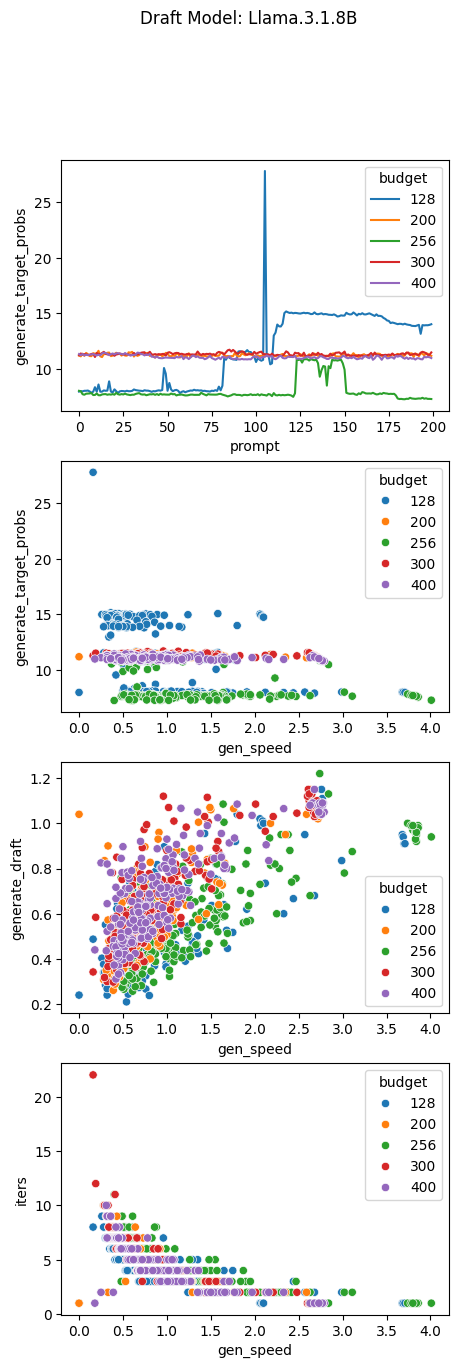

In [6]:
fig,axes = plt.subplots(4, 1, figsize=(5, 15))
plt.suptitle(f"Draft Model: {draft_model}")
sns.lineplot(data=results,x="prompt",y="generate_target_probs",hue="budget",ax=axes[0],palette=palette)
sns.scatterplot(data=results,x="gen_speed",y="generate_target_probs",hue="budget",ax=axes[1],palette=palette)
sns.scatterplot(data=results,x="gen_speed",y="generate_draft",hue="budget",ax=axes[2],palette=palette)
sns.scatterplot(data=results,x="gen_speed",y="iters",hue="budget",ax=axes[3],palette=palette)

In [9]:
#avg gen speed, gen rate new_tokens, run_airllm_count, latency
columns = ["method","model", "draft_model", "budget", "gen_speed", "gen_rate","generate_draft","generate_target_probs"]
results[columns].groupby(["method","model", "draft_model","budget"]).agg(["mean"])

gen_speed gen_rate generate_draft  \
                                              mean     mean           mean   
method model         draft_model  budget                                     
SX+A   Llama-3.1-70B Llama.3.1.8B 128      0.90080  10.0365       0.510578   
                                  200      0.93860  11.2275       0.625435   
                                  256      1.33680  11.5010       0.575570   
                                  300      0.96095  11.6275       0.665123   
                                  400      0.98190  11.6120       0.690144   

                                         generate_target_probs  
                                                          mean  
method model         draft_model  budget                        
SX+A   Llama-3.1-70B Llama.3.1.8B 128                11.492679  
                                  200                11.221417  
                                  256                 8.036307  
                                  300                11.315413  
                                  400                11.050554

<Axes: xlabel='budget', ylabel='gen_speed'>

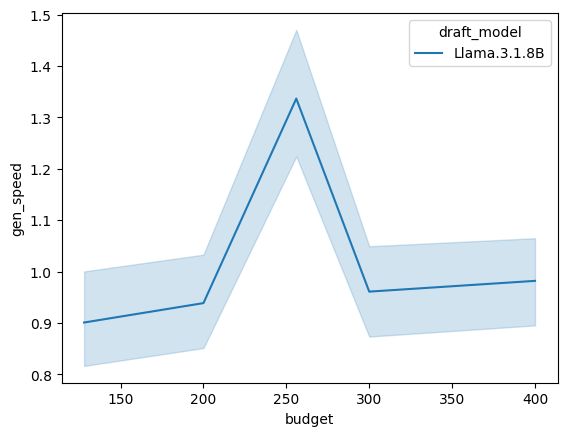

In [10]:
sns.lineplot(data=results, x="budget",y="gen_speed", hue="draft_model")

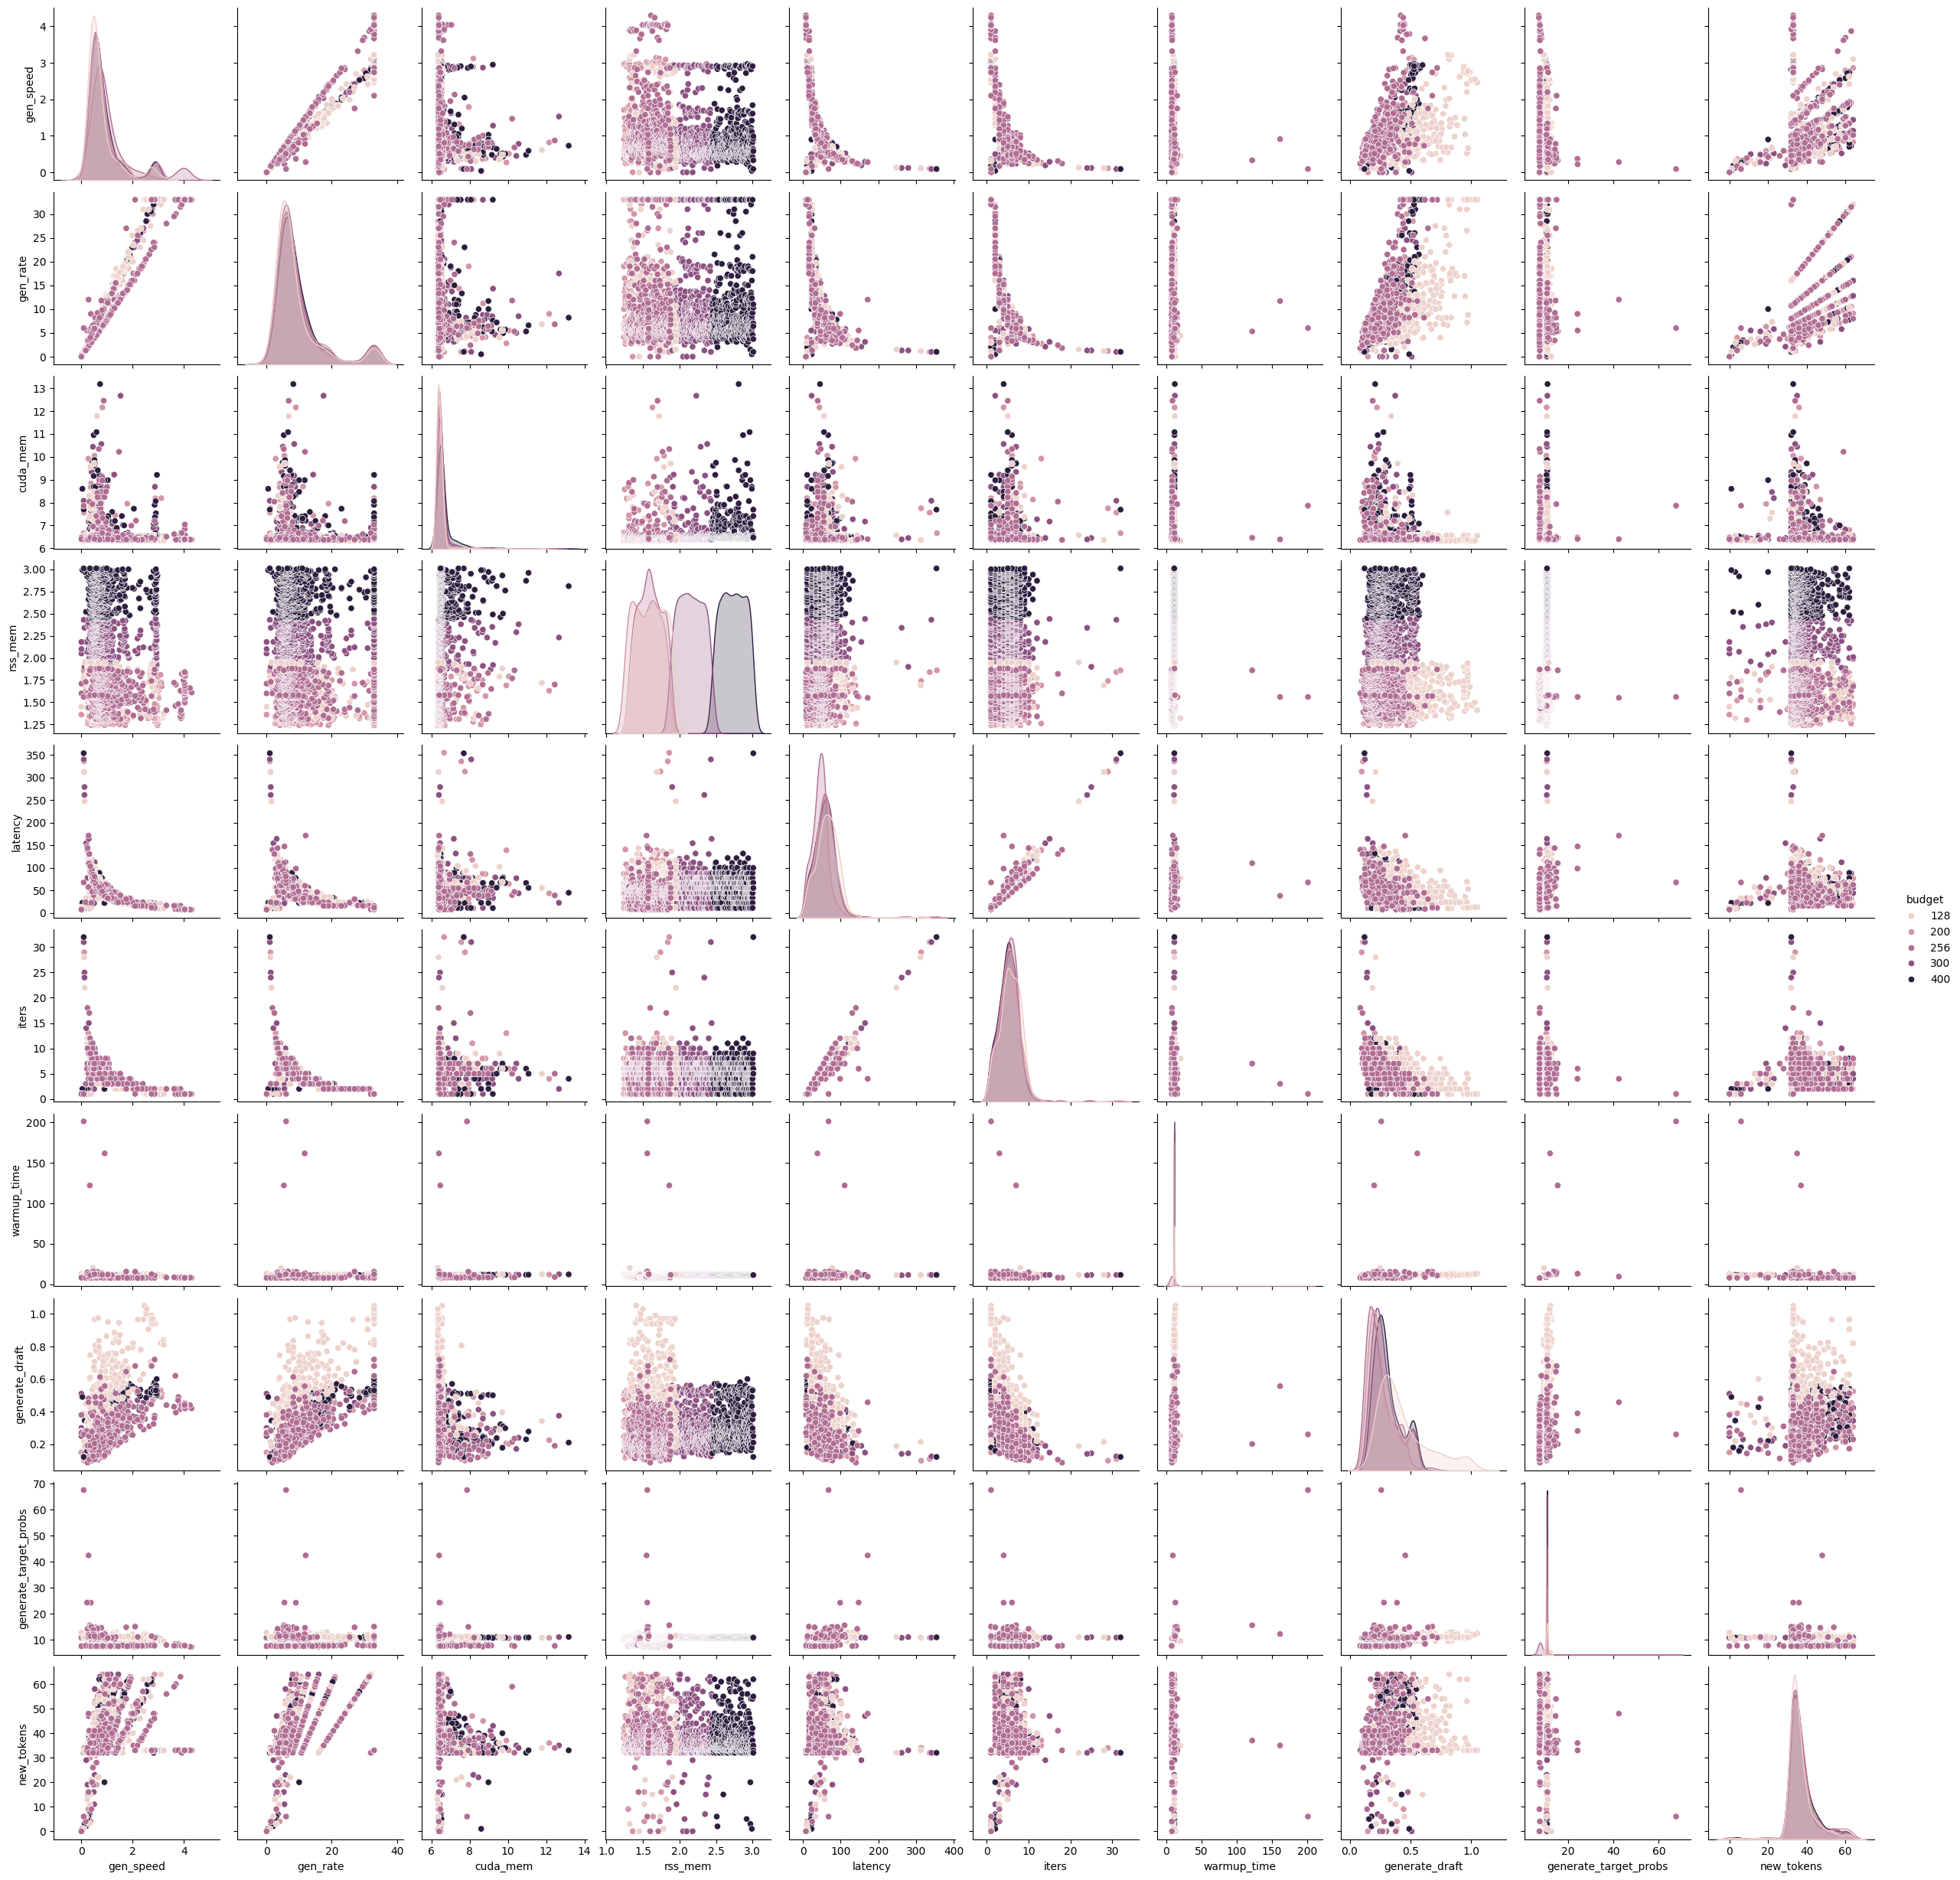

In [10]:
col = [ 'budget', 'gen_speed', 'gen_rate', 'cuda_mem',
       'rss_mem', 'latency', 'iters', 'warmup_time', 'generate_draft',
       'generate_target_probs', 'new_tokens']
sns.pairplot(data=results[col], hue="budget")